In [42]:
import Data_acq as data
from models import Encoder
from models import Decoder
from models import cVAE
import importlib

Datos

In [21]:
import importlib
importlib.reload(data)
x_train, x_test,x_val ,y_train, y_test,y_val = data.get_mnist_data()

print("="*70)
print(f"x_train: {x_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"x_val: {x_val.shape}\n")
print("-"*70)
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")
print(f"y_val: {y_val.shape}\n")
print("primer elemento")
print(f"primer elemento del set de entrenamineto shape: {x_train[0].shape}\n")
print(f"primer elemento del set de entrenamineto: {x_train[0]}")

print(f"primer label del set de entrenamineto shape: {y_train[0].shape}\n")
print(f"primer label del set de entrenamineto: {y_train[0]}")

print("="*70)


x_train: (55000, 28, 28)
x_test: (10000, 28, 28)
x_val: (5000, 28, 28)

----------------------------------------------------------------------
y_train: (55000, 10)
y_test: (10000, 10)
y_val: (5000, 10)

primer elemento
primer elemento del set de entrenamineto shape: (28, 28)

primer elemento del set de entrenamineto: [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0

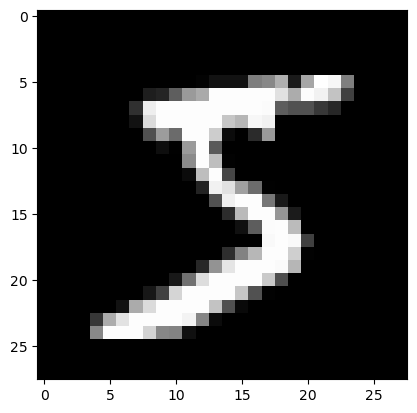

In [22]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0],cmap="gray")
plt.show()

Enconder

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
[[1.6278749  0.38714197]]
[[-0.38778782  0.01806626]]
[[0.05729766 0.31056562]]
(28, 28)


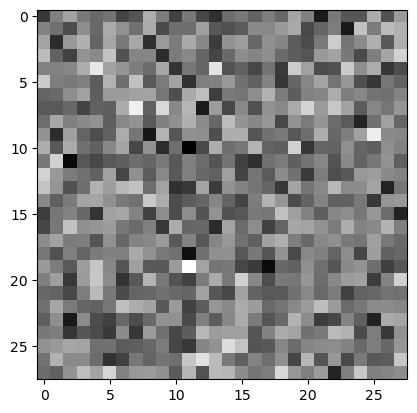

In [ ]:
import importlib
import numpy as np
importlib.reload(Encoder)
importlib.reload(Decoder)
en = Encoder.build_enconder()
de = Decoder.build_decoder()


img_sample = np.expand_dims(x_train[0], axis=0)  # shape (1, 28, 28)
cond_sample = np.expand_dims(y_train[0], axis=0) 

[z, z_mean, z_log_var] = en.predict([img_sample,cond_sample])

img_recons = de.predict([z,cond_sample])

print(z)
print(z_mean)
print(z_log_var)
print(img_recons[0].shape)

plt.imshow(img_recons[0],cmap="gray")
plt.show()


In [44]:
importlib.reload(cVAE)
original_dim=28*28
beta=1.0

cVAE = cVAE.build_cvae(en,de)

cvae = CVAE(encoder=en, decoder=de, original_dim=original_dim, beta=beta)
cvae.compile(optimizer='adam')


cvae.fit((x_train, c_train), y_train, epochs=10, batch_size=32)


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.ops`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```
